In [1]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
grandparentdir = os.path.dirname(parentdir)
sys.path.insert(0, parentdir) 
sys.path.insert(0, grandparentdir)

from bmvc import *
from simulations.simulations import *
from sklearn.preprocessing import scale
from pickle import load
from runners import *
import autograd.numpy as np

## Configurations

In [2]:
# Simulation parameters
sim_rs = 1 # random seed 
p = 0.5 # binomial randomness parameter
shift = 0.5 # size of shift 
n = 100  # number of samples per clsuter
n_shift = 50 # number of samples to shift
sigma = 0.3 # variance of Gaussians
K = 4 # number of clusters

In [3]:
# Clustering parameters
phi = None # infer phi; if None, then infer. otherwise, fix to phi value
phi_mean_prior = 0  # gaussian mean prior on phi
phi_scale_prior = 1  # gaussian scale prior on phi
rs = 2 # random seed
iter = 10  # number of iterations
init= 'kmeans'  # initialization: 'kmeans' or 'random'
inference = 'alternating'  # inference option: 'alternating' or 'serial' (alternating recommended)
pseudo = True  # whether to use pseudolikelihood

## Simulation generation

In [4]:
if K == 2:
    clusters, n1, n2, sigma1, sigma2, R = two_cluster_sim(n, sigma)
    samples1, samples2, labels1, labels2 = generate_data_p_mod_gt(clusters, [n1, n2], [sigma1, sigma2], p, shift, n_shift, rs=sim_rs)
elif K == 4:
    clusters, n1, n2, sigma1, sigma2, R = four_cluster_baseline(n, sigma)
    samples1, samples2, labels1, labels2 = generate_data_baseline_mod(clusters, [n1, n2], [sigma1, sigma2], p, shift, n_shift, rs=sim_rs)

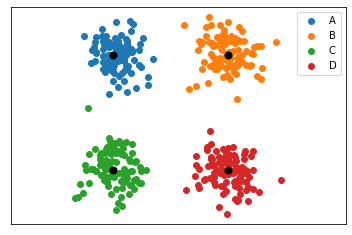

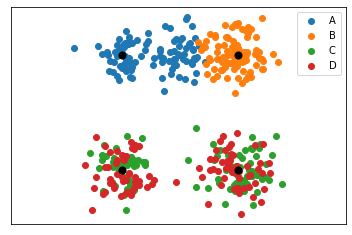

In [5]:
visualize_2d(clusters, clusters, samples1, samples2, labels1, labels2)

In [6]:
X1 = scale(samples1)
X2 = scale(samples2)

In [7]:
print("Confirming data is scaled...")
print(np.var(X1, 0))
print(np.var(X2, 0))
print(np.mean(X1, 0))
print(np.mean(X2, 0))

Confirming data is scaled...
[1. 1.]
[1. 1.]
[-2.43693954e-16  2.67008637e-16]
[8.27116153e-17 1.96509475e-16]


## BMVC analysis 

In [8]:
step_size = np.zeros(K*2 + K*2 + 2, dtype=float)
pi_step = 0.1
phi_step = 1
step_size[:K*2+K*2] = pi_step
step_size[K*2+K*2:] = phi_step

In [9]:
model, parameters = gen_gd_bmvc_results(X1, X2, R, K, 
                           phi=phi,
                           phi_mean_prior=phi_mean_prior,
                           phi_scale_prior=phi_scale_prior,
                           init=init,
                           random_state=rs,
                           iter=iter,
                           inference=inference,
                           step_size=step_size, 
                           pseudo=pseudo)

Initializing via kmeans...
Initial clustering: Counter({1: 101, 0: 100, 3: 100, 2: 99}) Counter({0: 119, 2: 106, 1: 94, 3: 81})
(4, 2) (4, 2)
Adjusting relationships... 1 3
Adjusted labeling: Counter({1: 101, 0: 100, 3: 100, 2: 99}) Counter({0: 119, 2: 106, 1: 94, 3: 81})
Optimizing variational parameters...
Iteration 0 objective [2711.08481446]
GRADIENT: [-3.13771054e-05 -5.65609407e-01  5.66359341e-01 -3.13771050e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.06197832e+01  3.39816395e+00 -3.39381416e+00  1.08882199e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.64021196e+02  0.00000000e+00]
NUM FUSED:  282
NUM GROUPED, VIEW 1:  400.0
NUM GROUPED, VIEW 2:  400.0
PHI 0.0 PHI MOD 1.0
Total log likelihood M2:  [-2711.08481446]
piA: [0.24999988 0.25042552 0.24957471 0.24999988]
piB: [0.25811888 0.24741022 0.25251414 0.24195676]
Reassigning...
Counter({1: 101, 0: 100, 3: 100, 2: 99}) Counter({0: 121, 2: 106, 1: 94, 3: 79})
Total log likel

Total log likelihood M2:  [-966.3182573]
piA: [0.24208123 0.23734532 0.25039305 0.2701804 ]
piB: [0.29106185 0.23628635 0.26394388 0.20870792]
Reassigning...
Counter({1: 100, 0: 100, 2: 100, 3: 100}) Counter({2: 106, 3: 100, 0: 100, 1: 94})
Total log likelihood, E:  [-966.3182573]
Total log likelihood, M.1:  [-966.3182573]
Adjusted labeling: Counter({1: 100, 0: 100, 2: 100, 3: 100}) Counter({2: 106, 3: 100, 0: 100, 1: 94})
Total log likelihood, A:  [-966.3182573]
Iteration 8 objective [962.96325953]
PARAM DIFF: [ 0.0477274  -0.00362105 -0.04001729 -0.0192809   0.          0.
  0.          0.         -0.05555121 -0.01517893  0.01644762  0.05886861
  0.          0.          0.          0.          0.44779757  0.        ]
GRADIENT: [ 0.16310575 -2.25856439  1.35206288  0.69475492  0.          0.
  0.          0.          5.27890312  1.29228623 -0.93626207 -6.10076433
  0.          0.          0.          0.         -3.82783341  0.        ]
NUM FUSED:  302
NUM GROUPED, VIEW 1:  400.0
NUM G

Results colored by ground truth cluster labels.


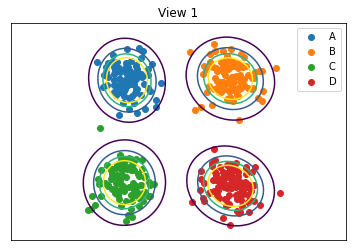

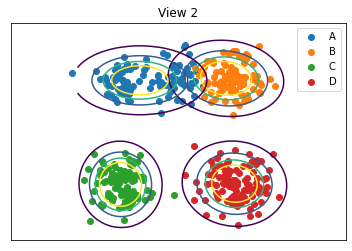

Results colored by inferred cluster labels.


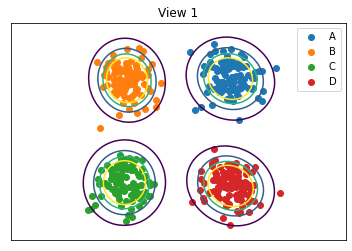

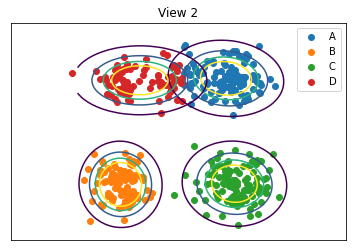

In [17]:
print("Results colored by ground truth cluster labels.")
visualize_2d_results(X1, X2, labels1, labels2, model.muA, model.muB, model.sigmaA, model.sigmaB)
print("Results colored by inferred cluster labels.")
visualize_2d_results(X1, X2, model.zA, model.zB, model.muA, model.muB, model.sigmaA, model.sigmaB)

In [11]:
compare_clusterings_ari(labels1, model.zA, 'ARI MVC View 1')
compare_clusterings_ari(labels2, model.zB, 'ARI MVC View 2')

ARI MVC View 1 score: 1.0
ARI MVC View 2 score: 1.0


1.0

## H-GMM analysis 

In [12]:
phi = 0
pseudo = False
step_size = np.zeros(K*2 + K*2, dtype=float)
pi_step = 0.1
phi_step = 1
step_size[:K*2+K*2] = pi_step

In [13]:
model, parameters = gen_gd_bmvc_results(X1, X2, R, K, 
                           phi=phi,
                           phi_mean_prior=phi_mean_prior,
                           phi_scale_prior=phi_scale_prior,
                           init=init,
                           random_state=rs,
                           iter=iter,
                           inference=inference,
                           step_size=step_size,
                           pseudo=pseudo)

Initializing via kmeans...
Initial clustering: Counter({1: 101, 0: 100, 3: 100, 2: 99}) Counter({0: 119, 2: 106, 1: 94, 3: 81})
(4, 2) (4, 2)
Adjusting relationships... 1 3
Adjusted labeling: Counter({1: 101, 0: 100, 3: 100, 2: 99}) Counter({0: 119, 2: 106, 1: 94, 3: 81})
Optimizing variational parameters...
Iteration 0 objective [2711.08481446]
GRADIENT: [-3.13771056e-05 -5.65609407e-01  5.66359341e-01 -3.13771056e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.06197832e+01  3.39816395e+00 -3.39381416e+00  1.08882199e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
NUM FUSED:  282
NUM GROUPED, VIEW 1:  400.0
NUM GROUPED, VIEW 2:  400.0
PHI 0.0 PHI MOD 1.0
Total log likelihood M2:  [-2711.08481446]
piA: [0.24999988 0.25042552 0.24957471 0.24999988]
piB: [0.25811888 0.24741022 0.25251414 0.24195676]
Reassigning...
Counter({1: 101, 0: 100, 3: 100, 2: 99}) Counter({0: 121, 2: 106, 1: 94, 3: 79})
Total log likelihood, E:  [-2711.02796962]
Total

Iteration 8 objective [1387.55528764]
PARAM DIFF: [ 0.02675537  0.03142463 -0.02655637  0.02675537  0.          0.
  0.          0.         -0.02485236 -0.00974181  0.02245007  0.02875159
  0.          0.          0.          0.        ]
GRADIENT: [ 0.78831638  1.00853389 -2.64813     0.78831638  0.          0.
  0.          0.          2.8125695   1.19543229 -0.28859115 -4.32427945
  0.          0.          0.          0.        ]
NUM FUSED:  281
NUM GROUPED, VIEW 1:  400.0
NUM GROUPED, VIEW 2:  400.0
PHI 0.0 PHI MOD 1.0
Total log likelihood M2:  [-1387.55528764]
piA: [0.25295953 0.25633    0.23775095 0.25295953]
piB: [0.30944511 0.23671365 0.26656942 0.18727182]
Reassigning...
Counter({1: 101, 0: 100, 3: 100, 2: 99}) Counter({0: 119, 2: 107, 1: 93, 3: 81})
Total log likelihood, E:  [-1387.55528764]
Total log likelihood, M.1:  [-1387.55528764]
Adjusted labeling: Counter({1: 101, 0: 100, 3: 100, 2: 99}) Counter({0: 119, 2: 107, 1: 93, 3: 81})
Total log likelihood, A:  [-1387.55528764]


Results colored by ground truth cluster labels.


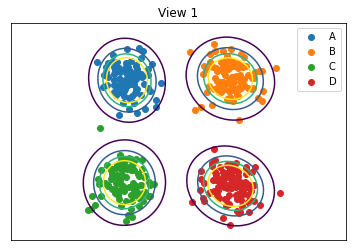

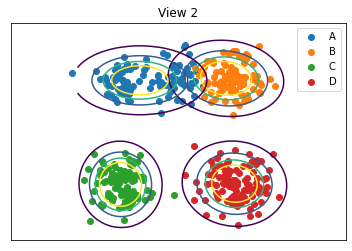

Results colored by inferred cluster labels.


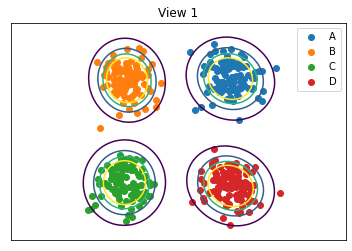

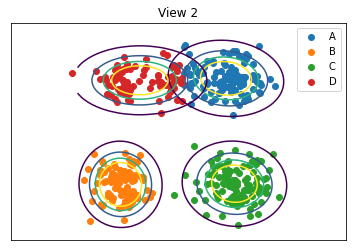

In [14]:
print("Results colored by ground truth cluster labels.")
visualize_2d_results(X1, X2, labels1, labels2, model.muA, model.muB, model.sigmaA, model.sigmaB)
print("Results colored by inferred cluster labels.")
visualize_2d_results(X1, X2, model.zA, model.zB, model.muA, model.muB, model.sigmaA, model.sigmaB)

In [15]:
compare_clusterings_ari(labels1, model.zA, 'ARI GMM View 1')
compare_clusterings_ari(labels2, model.zB, 'ARI GMM View 2')

ARI GMM View 1 score: 0.9933165272203728
ARI GMM View 2 score: 0.8787282514695854


0.8787282514695854

## Merged GMM analysis 

We only run this in the 4 cluster simulations. 

Merged GMM, View 1 score: 1.0
Merged GMM, View 2 score: 0.6644801196846769


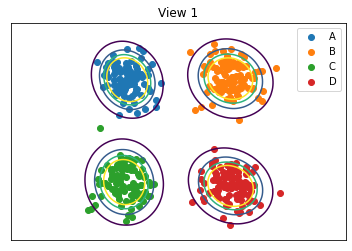

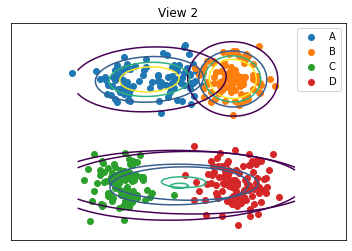

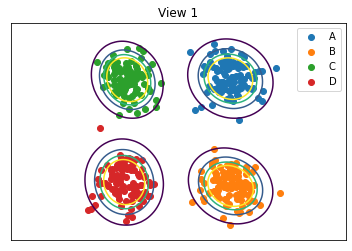

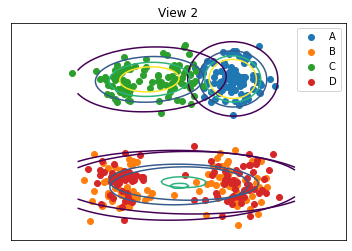

In [16]:
if K == 4:
    merged_samples = np.concatenate((np.array(samples1), np.array(samples2)), 1)
    X = scale(merged_samples)
    gmm = GaussianMixture(n_components=K, random_state=rs)
    gmm_z = gmm.fit(X).predict(X)
    ari_gmm_view1 = compare_clusterings_ari(labels1, gmm_z, 'Merged GMM, View 1')
    ari_gmm_view2 = compare_clusterings_ari(labels2, gmm_z, 'Merged GMM, View 2')
    
    visualize_2d_results(X[:, :2], X[:, 2:4], labels1, labels2, gmm.means_[:,:2], gmm.means_[:, 2:4], [covariance[0:2, 0:2] for covariance in gmm.covariances_], [covariance[2:4, 2:4] for covariance in gmm.covariances_])
    visualize_2d_results(X[:, :2], X[:, 2:4], gmm_z, gmm_z, gmm.means_[:,:2], gmm.means_[:, 2:4], [covariance[0:2, 0:2] for covariance in gmm.covariances_], [covariance[2:4, 2:4] for covariance in gmm.covariances_])

## 